In [1]:
import pandas as pd
import numpy as np
import time
from sklearn.ensemble import RandomForestRegressor
%matplotlib inline

#df = pd.read_csv("train_sub.csv").set_index("key").dropna()
#df = df.rename(columns={"Unnamed: 0": "index"})
#df.head()

In [2]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

#sc=pyspark.SparkContext("local[*]","First program in Spark")

In [4]:
def to_radians(deg):
    return deg * np.pi / 180.

def haversine(lat1, lat2, lon1, lon2):
    r = 6371*10**3
    phi1 = to_radians(lat1)
    phi2 = to_radians(lat2)
    delta_phi = phi2 - phi1
    delta_lambda = to_radians(lon2 - lon1)
    
    a = (np.sin(delta_phi / 2) **2 + 
         np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda/2)**2)
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1-a))
    return r * c


In [5]:
def encode_periodic(name, val, period):
    rad_val = val * 2. * np.pi / period
    return {'cos_'+name: np.cos(rad_val), 'sin_'+name: np.sin(rad_val)}

In [39]:
df = pd.read_csv("train.csv", nrows = 10)
df


,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,2009-06-15 17:26:21.0000001,4.5,2009-06-15 17:26:21 UTC,-73.844311,40.721319,-73.841610,40.712278,1
1,2010-01-05 16:52:16.0000002,16.9,2010-01-05 16:52:16 UTC,-74.016048,40.711303,-73.979268,40.782004,1
2,2011-08-18 00:35:00.00000049,5.7,2011-08-18 00:35:00 UTC,-73.982738,40.761270,-73.991242,40.750562,2
3,2012-04-21 04:30:42.0000001,7.7,2012-04-21 04:30:42 UTC,-73.987130,40.733143,-73.991567,40.758092,1
4,2010-03-09 07:51:00.000000135,5.3,2010-03-09 07:51:00 UTC,-73.968095,40.768008,-73.956655,40.783762,1
5,2011-01-06 09:50:45.0000002,12.1,2011-01-06 09:50:45 UTC,-74.000964,40.731630,-73.972892,40.758233,1
6,2012-11-20 20:35:00.0000001,7.5,2012-11-20 20:35:00 UTC,-73.980002,40.751662,-73.973802,40.764842,1
7,2012-01-04 17:22:00.00000081,16.5,2012-01-04 17:22:00 UTC,-73.951300,40.774138,-73.990095,40.751048,1
8,2012-12-03 13:10:00.000000125,9.0,2012-12-03 13:10:00 UTC,-74.006462,40.726713,-73.993078,40.731628,1
9,2009-09-02 01:11:00.00000083,8.9,2009-09-02 01:11:00 UTC,-73.980658,40.733873,-73.991540,40.758138,2


## Benchmarking de différentes méthodes de machine learning

In [3]:
## Benchmark des forêts aléatoires, je calcule le temps d'entrainement en fonction de la taille du dataset. 
r = np.logspace(3, 6, num = 10)
exec_time = [] 

#méthode Sklearn
rf = RandomForestRegressor(n_estimators = 20, n_jobs = -1)

for i in r:
    df = pd.read_csv("train.csv", nrows = np.floor(i)).dropna()
    
    X = df.drop(['key', 'fare_amount', 'pickup_datetime'], axis = 1).values
    y = df['fare_amount']
    
    start = time.time()
    rf.fit(X, y)
    end = time.time()
    exec_time.append(end - start)
    del df 

In [6]:
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.mllib.util import MLUtils
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import Vector
r = np.logspace(3, 6, num = 10)

exec_time_spark = []

#Méthode MLib
for i in r:
    data = spark.read.format("csv").option("header","true").load("train.csv").limit(int(np.floor(i))).drop("key").drop("pickup_datetime")
    d = data.rdd.map(lambda line: LabeledPoint(line[0],[line[1:]]))
    
    start = time.time()
    model = RandomForest.trainRegressor(d, {}, 20)
    end = time.time()
    exec_time_spark.append(end - start)
    del data
    del d


In [7]:
exec_time_spark


[4.374983787536621,
 1.4166290760040283,
 1.4863300323486328,
 1.8764750957489014,
 2.9208199977874756,
 6.108476877212524,
 12.859432935714722,
 26.700127840042114,
 55.830878019332886,
 128.21382403373718]

In [8]:
exec_time

[0.17541790008544922,
 0.15650105476379395,
 0.23791217803955078,
 0.5414719581604004,
 1.1494719982147217,
 2.5318830013275146,
 5.863595008850098,
 13.579121828079224,
 32.219050884246826,
 76.52887606620789]

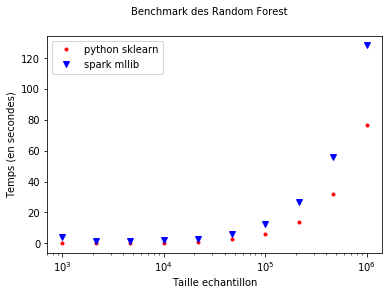

In [10]:
import matplotlib.pyplot as plt


fig = plt.figure()
fig.suptitle('Benchmark des Random Forest', fontsize=10)

ax = fig.add_subplot(111)

ax.set_xlabel('Taille echantillon')
ax.set_ylabel('Temps (en secondes)')


plt.xscale('log')
plt.plot(r, exec_time, 'r.', label = 'python sklearn')
plt.plot(r, exec_time_spark, 'bv', label = 'spark mllib')
plt.legend()
plt.show()

plt.savefig('rf.png')

#on remaque qu'il faut "chauffer" la JVM


# Benchmarking de méthodes BigData

In [6]:
## On test 3 requêtes respectivement sur pandas et pyspark (insipiré de https://databricks.com/blog/2018/05/03/benchmarking-apache-spark-on-a-single-node-machine.html)

#domaine d'échantillonage
r = np.logspace(4, 7, num = 10)

## -- Pandas --

q1 = []
q2 = []
q3 = []

for i in r:
    #requete 1: moyenne du prix
    df = pd.read_csv("train.csv", nrows = np.floor(i)).dropna()
    start = time.time()
    df[['fare_amount']].mean()
    end = time.time()
    q1.append(end - start)
    
    #requete 2: combien de trajets comportant un certain nombre de passagers ?
    start = time.time()
    df[['passenger_count']].nunique()
    end = time.time()
    q2.append(end - start)
    
    #requete 3: prix moyen pour un nombre de passagers
    start = time.time()
    df[['fare_amount', 'passenger_count']].groupby('passenger_count').mean()
    end = time.time()
    q3.append(end - start)    

In [8]:
df

NameError: name 'df' is not defined

NameError: name 'q1' is not defined

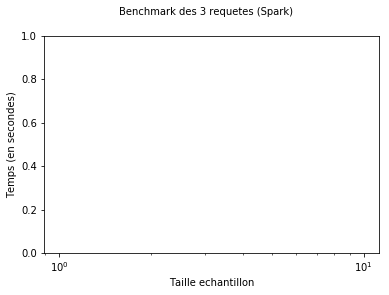

In [6]:
import matplotlib.pyplot as plt


fig = plt.figure()
fig.suptitle('Benchmark des 3 requetes', fontsize=10)

ax = fig.add_subplot(111)

ax.set_xlabel('Taille echantillon')
ax.set_ylabel('Temps (en secondes)')


plt.xscale('log')
plt.plot(r, q1, 'r.', label = 'requete 1')
plt.plot(r, q2, 'bv', label = 'requete 2')
plt.plot(r, q3, 'gx', label = 'requete 3')
plt.legend()

In [4]:
## -- Spark --
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)

r = np.logspace(4, 7, num = 10)

q1_spark = []
q2_spark = []
q3_spark = []


for i in r:
    
    data = spark.read.format("csv").option("header", "true").load("train.csv").limit(int(np.floor(i)))
    data.registerTempTable("t")
    
    #requete 1
    start = time.time()
    sqlContext.sql("select mean(fare_amount) from t").collect()
    end = time.time()
    q1_spark.append(end - start)

    #requete 2
    start = time.time()
    sqlContext.sql("select count(distinct passenger_count) from t").collect()
    end = time.time()
    q2_spark.append(end - start)

    #requete3
    start = time.time()
    sqlContext.sql("select mean(fare_amount) from t group by passenger_count").collect()
    end = time.time()
    q3_spark.append(end - start)

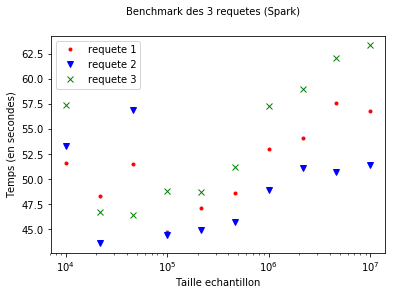

In [7]:
import matplotlib.pyplot as plt


fig = plt.figure()
fig.suptitle('Benchmark des 3 requetes (Spark)', fontsize=10)

ax = fig.add_subplot(111)

ax.set_xlabel('Taille echantillon')
ax.set_ylabel('Temps (en secondes)')


plt.xscale('log')
plt.plot(r, q1_spark, 'r.', label = 'requete 1')
plt.plot(r, q2_spark, 'bv', label = 'requete 2')
plt.plot(r, q3_spark, 'gx', label = 'requete 3')
plt.legend()

In [5]:
from pyspark.sql import SQLContext
sqlContext = SQLContext(spark)


data = spark.read.format("csv").option("header", "true").load("train.csv").limit(10**4)
data.registerTempTable("t")
a = time.time()
sqlContext.sql("select mean(fare_amount) from t").collect()
b = time.time()
print(b - a)

42.1264209747


In [9]:
df = df.assign(
    fly_distance=lambda f: haversine(f.pickup_latitude, f.dropoff_latitude,
                           f.pickup_longitude, f.dropoff_longitude),
    pickup_datetime=lambda f: pd.to_datetime(f['pickup_datetime']),
    year=lambda f: f.pickup_datetime.dt.year,
    month=lambda f: f.pickup_datetime.dt.month,
    dayofweek=lambda f: f.pickup_datetime.dt.dayofweek,
    dayofyear=lambda f: f.pickup_datetime.dt.dayofyear,
    hour=lambda f: f.pickup_datetime.dt.hour,
#    time_seconds=lambda f: (f.pickup_datetime - f.pickup_datetime.dt.normalize()).dt.total_seconds(),
)

df = df.assign(**encode_periodic("month", df.month, 12),
               **encode_periodic("hour", df.hour, 24),
               **encode_periodic("dayofweek", df.dayofweek, 6))

SyntaxError: invalid syntax (<ipython-input-9-75161d3ba972>, line 13)

In [111]:
from sklearn.model_selection import train_test_split

X, y = df.drop(["fare_amount", "index", "pickup_datetime"], axis=1), df["fare_amount"]
X_tr, X_te, y_tr, y_te = train_test_split(X, y, random_state=10)
X_tr.describe()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fly_distance,year,month,dayofweek,dayofyear,hour,cos_month,sin_month,cos_hour,sin_hour,cos_dayofweek,sin_dayofweek
count,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06,2.078385e+06
mean,-7.251425e+01,3.992817e+01,-7.253065e+01,3.993464e+01,1.685795e+00,2.004635e+04,2.011740e+03,6.268470e+00,3.040544e+00,1.752862e+02,1.351811e+01,-1.736222e-02,5.449276e-02,-6.729687e-02,-1.969714e-01,1.061382e-01,-1.769565e-02
std,1.236132e+01,9.919439e+00,1.262611e+01,9.648957e+00,1.353914e+00,3.736153e+05,1.860338e+00,3.434539e+00,1.949258e+00,1.047361e+02,6.517922e+00,7.066481e-01,7.052503e-01,7.146465e-01,6.677981e-01,7.386955e-01,6.653954e-01
min,-2.635312e+03,-3.084304e+03,-3.323171e+03,-2.892473e+03,0.000000e+00,0.000000e+00,2.009000e+03,1.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-8.660254e-01
25%,-7.399206e+01,4.073493e+01,-7.399141e+01,4.073400e+01,1.000000e+00,1.212170e+03,2.010000e+03,3.000000e+00,1.000000e+00,8.500000e+01,9.000000e+00,-8.660254e-01,-5.000000e-01,-7.071068e-01,-8.660254e-01,-5.000000e-01,-8.660254e-01
50%,-7.398181e+01,4.075264e+01,-7.398016e+01,4.075314e+01,1.000000e+00,2.115747e+03,2.012000e+03,6.000000e+00,3.000000e+00,1.670000e+02,1.400000e+01,6.123234e-17,1.224647e-16,-2.588190e-01,-2.588190e-01,5.000000e-01,0.000000e+00
75%,-7.396710e+01,4.076710e+01,-7.396366e+01,4.076811e+01,2.000000e+00,3.877335e+03,2.013000e+03,9.000000e+00,5.000000e+00,2.670000e+02,1.900000e+01,5.000000e-01,8.660254e-01,7.071068e-01,5.000000e-01,1.000000e+00,8.660254e-01
max,3.439426e+03,2.966973e+03,3.440830e+03,3.351403e+03,2.080000e+02,1.818686e+07,2.015000e+03,1.200000e+01,6.000000e+00,3.660000e+02,2.300000e+01,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,8.660254e-01


In [112]:
X.head()

,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count,fly_distance,year,month,dayofweek,dayofyear,hour,cos_month,sin_month,cos_hour,sin_hour,cos_dayofweek,sin_dayofweek
key,,,,,,,,,,,,,,,,,
2011-06-18 10:36:00.00000080,-73.984117,40.733587,-73.995832,40.730342,1,1050.989917,2011,6,5,169,10,-1.000000,1.224647e-16,-0.866025,0.500000,0.5,-8.660254e-01
2012-12-03 19:53:00.000000244,-73.972180,40.762890,-73.977372,40.776880,1,1615.894214,2012,12,0,338,19,1.000000,-2.449294e-16,0.258819,-0.965926,1.0,0.000000e+00
2014-01-16 22:48:00.00000046,-73.999018,40.728017,-74.007102,40.708132,5,2313.695001,2014,1,3,16,22,0.866025,5.000000e-01,0.866025,-0.500000,-1.0,1.224647e-16
2010-11-21 14:32:42.0000001,-73.986845,40.759359,-73.785880,40.643440,2,21287.166160,2010,11,6,325,14,0.866025,-5.000000e-01,-0.866025,-0.500000,1.0,-2.449294e-16
2013-05-02 07:41:00.00000089,-73.987285,40.718622,-73.959295,40.778482,1,7061.411037,2013,5,3,122,7,-0.866025,5.000000e-01,-0.258819,0.965926,-1.0,1.224647e-16


In [115]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor

cross_val_score(RandomForestRegressor(10), X, y, cv=3, scoring='r2')

C:\Users\Horace\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Horace\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Horace\Miniconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


array([0.78137143, 0.7820926 , 0.78215134])